In [1]:
import pandas as pd
import numpy as np
data = pd.read_excel("../data/rule_data.xlsx")
data.head()

,uid,oil_actv_dt,create_dt,total_oil_cnt,pay_amount_total,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source
0,A8217710,2018-08-19,2018-08-17,275.0,48295495.4,B,0,3308.56,1760081.0,1796001.0,1731081.0,8655401.0,1.0,1.0,1,3,2,0,3
1,A8217710,2018-08-19,2018-08-16,275.0,48295495.4,B,0,4674.68,2487045.0,2537801.0,2437845.0,12189221.0,1.0,1.0,1,3,2,0,3
2,A8217710,2018-08-19,2018-08-15,275.0,48295495.4,B,0,1873.06,977845.0,997801.0,961845.0,4809221.0,1.0,1.0,1,2,2,0,3
3,A8217710,2018-08-19,2018-08-14,275.0,48295495.4,B,0,4837.78,2526441.0,2578001.0,2484441.0,12422201.0,1.0,1.0,1,2,2,0,3
4,A8217710,2018-08-19,2018-08-13,275.0,48295495.4,B,0,2586.38,1350441.0,1378001.0,1328441.0,6642201.0,1.0,1.0,1,2,2,0,3


In [2]:
#unique，获得字段的所有取值，用户评级在案例没有起到决策性因素
data['class_new'].unique()

array(['B', 'E', 'C', 'A', 'D', 'F'], dtype=object)

In [3]:
#按照字段类型不同，进行划分，用来做特征衍生（创建）
org_list = ['uid','create_dt','oil_actv_dt','class_new','bad_ind']
agg_list = ['oil_amount','discount_amount','sale_amount','amount','pay_amount','coupon_amount','payment_coupon_amount']
count_list = ['channel_code','oil_code','scene','source_app','call_source']


In [4]:
#进行数据拷贝
df = data[org_list].copy()
df[agg_list] = data[agg_list].copy()
df[count_list] = data[count_list].copy()


In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50609 entries, 0 to 50608
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   uid                    50609 non-null  object        
 1   create_dt              45665 non-null  datetime64[ns]
 2   oil_actv_dt            50609 non-null  datetime64[ns]
 3   class_new              50609 non-null  object        
 4   bad_ind                50609 non-null  int64         
 5   oil_amount             45665 non-null  float64       
 6   discount_amount        45665 non-null  float64       
 7   sale_amount            45665 non-null  float64       
 8   amount                 45665 non-null  float64       
 9   pay_amount             45665 non-null  float64       
 10  coupon_amount          45665 non-null  float64       
 11  payment_coupon_amount  45663 non-null  float64       
 12  channel_code           50609 non-null  int64         
 13  o

In [7]:
df.isna().sum()

uid                         0
create_dt                4944
oil_actv_dt                 0
class_new                   0
bad_ind                     0
oil_amount               4944
discount_amount          4944
sale_amount              4944
amount                   4944
pay_amount               4944
coupon_amount            4944
payment_coupon_amount    4946
channel_code                0
oil_code                    0
scene                       0
source_app                  0
call_source                 0
dtype: int64

In [10]:
#对时间字段进行填充
df2 = df.sort_values(['uid','create_dt'],ascending=False)

In [14]:
def time_fill(x,y):
    if str(x) == 'NaT':
        x = y
    return x
df2['create_dt'] = df2.apply(lambda x:time_fill(x['create_dt'],x['oil_actv_dt']),axis=1)


In [15]:
#金融风控场景下，不建议使用太久远的数据来训练，因此获取最近6个月的数据
df2['dtn'] = (df2['oil_actv_dt'] - df2['create_dt']).apply(lambda x:x.days)
df = df2[df2['dtn'] < 180]
df.head()

,uid,create_dt,oil_actv_dt,class_new,bad_ind,oil_amount,discount_amount,sale_amount,amount,pay_amount,coupon_amount,payment_coupon_amount,channel_code,oil_code,scene,source_app,call_source,dtn
50608,B96436391985035703,2018-10-08,2018-10-08,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50607,B96436391984693397,2018-10-11,2018-10-11,E,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50606,B96436391977217468,2018-10-17,2018-10-17,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50605,B96436391976480892,2018-09-28,2018-09-28,B,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0
50604,B96436391972106043,2018-10-19,2018-10-19,A,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,9,2,3,4,0


In [16]:
df.shape


(45039, 18)

In [17]:
#拿原生不用做特征衍生的字段来过滤行数据，保留第一条数据
base = df[org_list]
base = base.sort_values(['uid','create_dt'],ascending=False)

In [20]:
#Keep的取值：first，last
base = base.drop_duplicates(['uid'],keep='first')
base['dtn'] = df['dtn']
base.shape

(11099, 6)

In [21]:
#数值型衍生方式：各种聚合
gn = pd.DataFrame()
for i in agg_list:
    tp = df.groupby('uid').apply(lambda df:len(df[i])).reset_index()
    tp.columns = ['uid',i + '_cnt']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    #求历史特征值大于0的个数
    tp = df.groupby('uid').apply(lambda df:np.where(df[i]>0,1,0).sum()).reset_index()
    tp.columns = ['uid',i + '_num']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    #求和
    tp = df.groupby('uid').apply(lambda df:np.nansum(df[i])).reset_index()
    tp.columns = ['uid',i + '_tot']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    #求平均值
    tp = df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index()
    tp.columns = ['uid',i + '_avg']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    #求最大值
    tp = df.groupby('uid').apply(lambda df:np.nanmax(df[i])).reset_index()
    tp.columns = ['uid',i + '_max']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    #求最小值
    tp = df.groupby('uid').apply(lambda df:np.nanmin(df[i])).reset_index()
    tp.columns = ['uid',i + '_min']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    #求方差
    tp = df.groupby('uid').apply(lambda df:np.nanvar(df[i])).reset_index()
    tp.columns = ['uid',i + '_var']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')
    #求极差
    tp = df.groupby('uid').apply(lambda df:np.nanmax(df[i]) -np.nanmin(df[i]) ).reset_index()
    tp.columns = ['uid',i + '_ran']
    if gn.empty:
        gn = tp
    else:
        gn = pd.merge(gn,tp,on = 'uid',how = 'left')

<ipython-input-21-2bf0f70a2061>:24: RuntimeWarning: Mean of empty slice
  tp = df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index()
<ipython-input-21-2bf0f70a2061>:31: RuntimeWarning: All-NaN axis encountered
  tp = df.groupby('uid').apply(lambda df:np.nanmax(df[i])).reset_index()
<ipython-input-21-2bf0f70a2061>:38: RuntimeWarning: All-NaN axis encountered
  tp = df.groupby('uid').apply(lambda df:np.nanmin(df[i])).reset_index()
<ipython-input-21-2bf0f70a2061>:45: RuntimeWarning: Degrees of freedom <= 0 for slice.
  tp = df.groupby('uid').apply(lambda df:np.nanvar(df[i])).reset_index()
<ipython-input-21-2bf0f70a2061>:52: RuntimeWarning: All-NaN axis encountered
  tp = df.groupby('uid').apply(lambda df:np.nanmax(df[i]) -np.nanmin(df[i]) ).reset_index()
<ipython-input-21-2bf0f70a2061>:24: RuntimeWarning: Mean of empty slice
  tp = df.groupby('uid').apply(lambda df:np.nanmean(df[i])).reset_index()
<ipython-input-21-2bf0f70a2061>:31: RuntimeWarning: All-NaN axis encountered
  

In [22]:
gn.columns


Index(['uid', 'oil_amount_cnt', 'oil_amount_num', 'oil_amount_tot',
       'oil_amount_avg', 'oil_amount_max', 'oil_amount_min', 'oil_amount_var',
       'oil_amount_ran', 'discount_amount_cnt', 'discount_amount_num',
       'discount_amount_tot', 'discount_amount_avg', 'discount_amount_max',
       'discount_amount_min', 'discount_amount_var', 'discount_amount_ran',
       'sale_amount_cnt', 'sale_amount_num', 'sale_amount_tot',
       'sale_amount_avg', 'sale_amount_max', 'sale_amount_min',
       'sale_amount_var', 'sale_amount_ran', 'amount_cnt', 'amount_num',
       'amount_tot', 'amount_avg', 'amount_max', 'amount_min', 'amount_var',
       'amount_ran', 'pay_amount_cnt', 'pay_amount_num', 'pay_amount_tot',
       'pay_amount_avg', 'pay_amount_max', 'pay_amount_min', 'pay_amount_var',
       'pay_amount_ran', 'coupon_amount_cnt', 'coupon_amount_num',
       'coupon_amount_tot', 'coupon_amount_avg', 'coupon_amount_max',
       'coupon_amount_min', 'coupon_amount_var', 'coupon_amou

In [23]:
#分类型特征衍生：统计操作
gc = pd.DataFrame()
for i in count_list:
    tp = df.groupby('uid').apply(lambda df: len(set(df[i]))).reset_index()
    tp.columns = ['uid',i + '_dstc']
    if gc.empty:
        gc = tp
    else:
        gc = pd.merge(gc,tp,on = 'uid',how = 'left')


In [24]:
gc.columns


Index(['uid', 'channel_code_dstc', 'oil_code_dstc', 'scene_dstc',
       'source_app_dstc', 'call_source_dstc'],
      dtype='object')

In [26]:
#把刚刚衍生的特征都拼接起来
fn = pd.merge(base,gn,on='uid')
fn = pd.merge(fn,gc,on='uid')
fn.shape

(11099, 67)

In [28]:
#如果万一数据中出现缺失值，用0填充
fn.isna().sum()
fn = fn.fillna(0)
fn.head()

,uid,create_dt,oil_actv_dt,class_new,bad_ind,dtn,oil_amount_cnt,oil_amount_num,oil_amount_tot,oil_amount_avg,...,payment_coupon_amount_avg,payment_coupon_amount_max,payment_coupon_amount_min,payment_coupon_amount_var,payment_coupon_amount_ran,channel_code_dstc,oil_code_dstc,scene_dstc,source_app_dstc,call_source_dstc
0,B96436391985035703,2018-10-08,2018-10-08,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
1,B96436391984693397,2018-10-11,2018-10-11,E,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
2,B96436391977217468,2018-10-17,2018-10-17,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
3,B96436391976480892,2018-09-28,2018-09-28,B,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1
4,B96436391972106043,2018-10-19,2018-10-19,A,0,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,1,1,1


In [30]:
#训练模型
x = fn.drop(['uid','oil_actv_dt','create_dt','bad_ind','class_new'],axis=1)

In [31]:
y = fn['bad_ind'].copy()


In [34]:
from sklearn.tree import DecisionTreeRegressor,export_graphviz
dtree = DecisionTreeRegressor(max_depth=2,min_samples_leaf=500,min_samples_split=5000)

In [35]:
dtree.fit(x,y)


DecisionTreeRegressor(max_depth=2, min_samples_leaf=500, min_samples_split=5000)

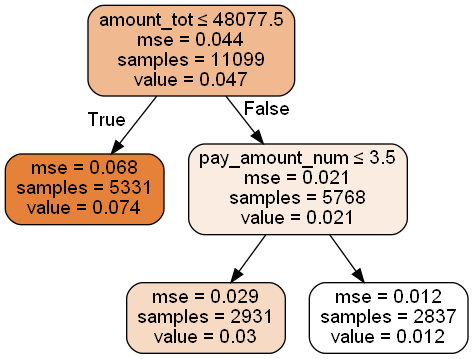

In [36]:
#画图，看一眼决策树
import pydotplus
from IPython.display import Image
from six import StringIO
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,
                         feature_names=x.columns,
                         class_names=['bad_ind'],
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


[Text(133.92000000000002, 181.2, 'amount_tot <= 48077.5\nmse = 0.044\nsamples = 11099\nvalue = 0.047'),
 Text(66.96000000000001, 108.72, 'mse = 0.068\nsamples = 5331\nvalue = 0.074'),
 Text(200.88000000000002, 108.72, 'pay_amount_num <= 3.5\nmse = 0.021\nsamples = 5768\nvalue = 0.021'),
 Text(133.92000000000002, 36.23999999999998, 'mse = 0.029\nsamples = 2931\nvalue = 0.03'),
 Text(267.84000000000003, 36.23999999999998, 'mse = 0.012\nsamples = 2837\nvalue = 0.012')]

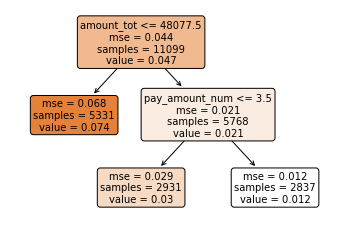

In [37]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plot_tree(dtree,feature_names=x.columns,
                         class_names=['bad_ind'],
                         filled=True, rounded=True)
